In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

In [3]:
table = pd.read_csv("tables_photometric/Hydra-Centaurus.csv", 
                    usecols=["RA", "DEC", "PROB_GAL", "zml", "r_petro", "g_petro"])

In [4]:
ra = table["RA"]
dec = table["DEC"]
probgal = table["PROB_GAL"]
zml = table["zml"]
rpetro = table["r_petro"]
gpetro = table["g_petro"]

In [5]:
#Defining the center of Hydra (in degress)
ra_0 = 159.17
dec_0 = -27.524

#Defining the radius of 1R200 around the center (in degrees)
#R200 = 1.4Mpc + scale of 0.247 Kpc/" ==> radius = 1.5744º
radius = 1.5744

### Preliminary RA x DEC plot of Hydra-Centaurus, showing some clusters and groups in the region

In [21]:
groups = ["Hydra", "NGC3393", "NGC3054", "NGC3087", "Antlia", "NGC3347", "NGC3250", "NGC3256", "NGC3263", "NGC3257"]
ra_groups = [ra_0, 162.09, 148.62, 149.79, 157.51, 160.69, 156.63, 156.96, 157.31, 157.19]
dec_groups = [dec_0, -25.16, -25.70, -34.23, -35.32, -36.35, -39.94, -43.90, -44.12, -35.66]

In [37]:
mlim = 21
mask = (rpetro < mlim) & (zml > 0.005) & (zml < 0.03) & (probgal > 0.8)

/tmp/ipykernel_531273/4106345909.py:30: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')


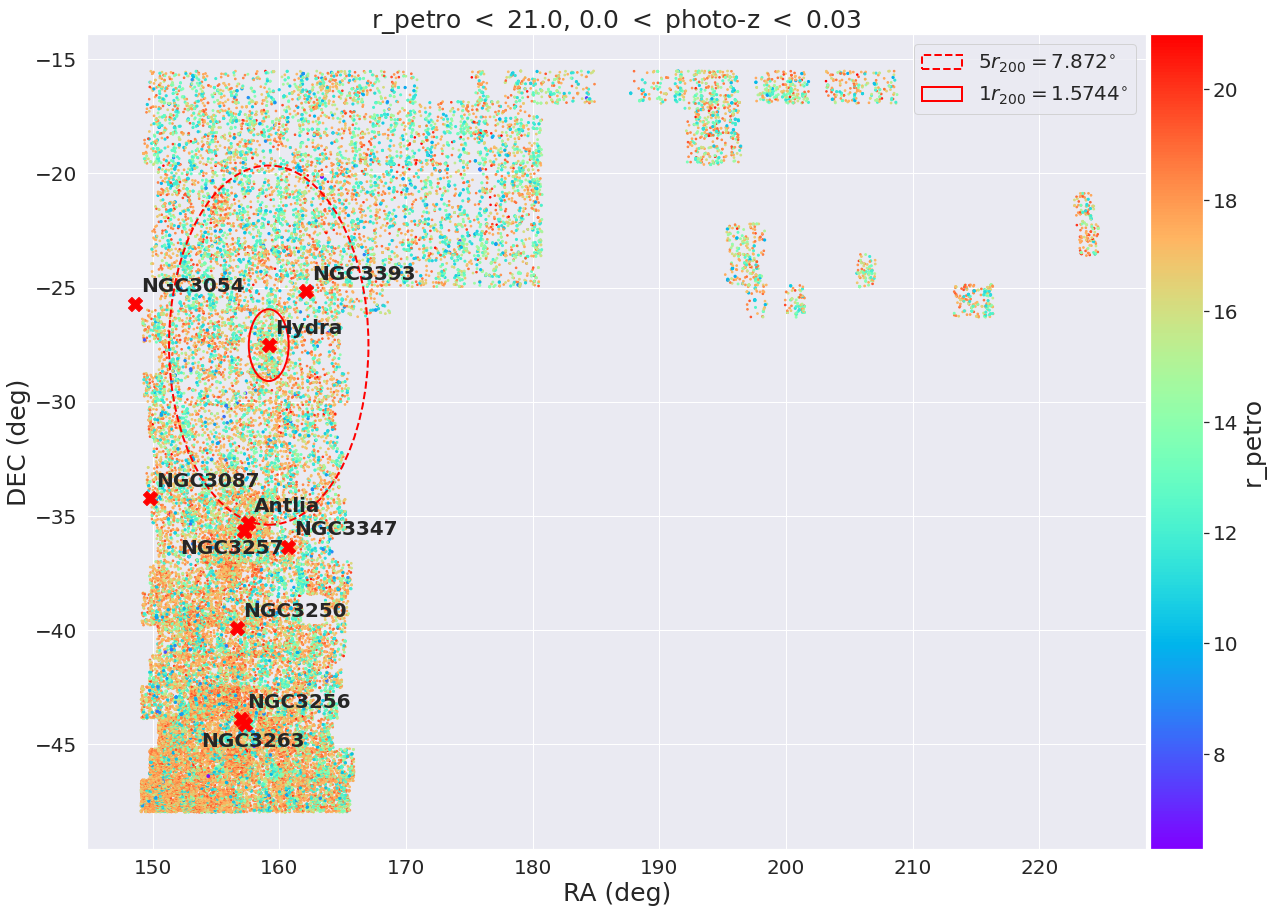

In [54]:
fontsize = 25
labelsize = 20

from mpl_toolkits.axes_grid1 import make_axes_locatable
cm1 = plt.cm.get_cmap('jet')
cm2 = plt.cm.get_cmap('rainbow')

fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111)

sc1 = ax.scatter(x=ra[mask], y=dec[mask], c=rpetro[mask], cmap=cm2, s=(1/rpetro[mask])*50)
ax.set_ylabel("DEC (deg)", fontsize=fontsize)
ax.set_xlabel("RA (deg)", fontsize=fontsize)
ax.set_title(r"r_petro $<$ {:.1f}, 0.0 $<$ photo-z $<$ 0.03".format(mlim), fontsize=fontsize)

ax.scatter(ra_groups, dec_groups, marker='X', s=200.0, color='red')

dx = 0.5
for ra_g, dec_g, text in zip(ra_groups, dec_groups, groups):
    if text=="NGC3257": ax.text(ra_g-10*dx, dec_g-2*dx, s=text, fontsize=20, fontweight='bold')
    elif text=="NGC3263": ax.text(ra_g-7*dx, dec_g-2*dx, s=text, fontsize=20, fontweight='bold')
    else: ax.text(ra_g+dx, dec_g+dx, s=text, fontsize=20, fontweight='bold')

divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="r_petro", fontsize=fontsize)
cbar.ax.tick_params(labelsize=labelsize)

FiveR200 = plt.Circle((ra_0, dec_0), 5*radius, linestyle='--', edgecolor='red', facecolor="None", lw=2, label=r'$5 r_{200} = 7.872^{\circ}$')
ax.add_patch(FiveR200)

OneR200 = plt.Circle((ra_0, dec_0), radius, linestyle='-', edgecolor='red', facecolor="None", lw=2, label=r'$1 r_{200} = 1.5744^{\circ}$')
ax.add_patch(OneR200)

ax.legend(fontsize=fontsize*0.8)
ax.xaxis.set_tick_params(labelsize=20, width=35)
ax.yaxis.set_tick_params(labelsize=20, width=35)


### Correct magnitudes by extinction

In [1]:
import extinction
import sfdmap

In [4]:
##################################################################################################
# Defining column names to load only what is needed
##################################################################################################
# Name of the filters for which the magnitudes will be corrected (as they appear on the .csv file)
Base_Filters   = ['r', 'g']

# This will add a `_aper_6` to the name of each filter in Base_Filters
Features_SPLUS = [filt+'_petro' for filt in Base_Filters]

# This will add a `_ext` to the name of each filter in Base_Filters
Extinct_SPLUS  = [filt+'_ext' for filt in Base_Filters]

# Choosing the wavelenghts that will be corrected (these are the effective wavelengths of the filters)
Lambdas = np.array([4751, 6258]).astype(np.float)

/tmp/ipykernel_3660/2145364968.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Lambdas = np.array([4751, 6258]).astype(np.float)


In [5]:
##################################################################################################
# Correcting magnitudes for the extinction
##################################################################################################
def correct_extinction(Dataframe, Extinction_Maps):
    '''
    Correct the magnitudes for extinction using the CCM89 Law

    Keyword arguments:
    Dataframe         -- Dataframe containing the data to be corrected (must have RA and DEC)
    Extinction_Maps   -- SFD Maps
    '''
    Corrected_Dataframe = Dataframe.copy().reset_index(drop=True)

    # Obtaining E(B-V) and Av in a given RA, DEC position
    AV = Extinction_Maps.ebv(Dataframe.RA, Dataframe.DEC)*3.1

    # Calculating the extinction on the S-PLUS bands using the Cardelli, Clayton & Mathis law.
    Extinctions = []
    for i in range(len(AV)):
        Extinctions.append(extinction.ccm89(Lambdas, AV[i], 3.1))

    Extinction_DF = pd.DataFrame(Extinctions, columns=Extinct_SPLUS)

    for i in range(len(Features_SPLUS)):
        Corrected_Dataframe[Features_SPLUS[i]] -= Extinction_DF[Extinct_SPLUS[i]]

    return Corrected_Dataframe

In [6]:
df = pd.read_csv("tables_photometric/Hydra-Centaurus.csv")

dust_maps = sfdmap.SFDMap('../Correct_Extinction/DustMaps/')

mlim = 21
mask = (df["r_petro"] < mlim) & (df["zml"] > 0.005) & (df["zml"] < 0.03) & (df["PROB_GAL"] > 0.8)

corrected_df = correct_extinction(df.loc[mask], dust_maps)

In [35]:
ra_cor = corrected_df.RA
dec_cor = corrected_df.DEC
probgal_cor = corrected_df.PROB_GAL
zml_cor = corrected_df.zml
rpetro_cor = corrected_df.r_petro
gpetro_cor = corrected_df.g_petro

In [56]:
mlim = 18
mask_cor = (rpetro_cor < 18) & (zml_cor > 0.005) & (zml_cor < 0.03) & (probgal_cor > 0.8)

/tmp/ipykernel_3660/917673108.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')


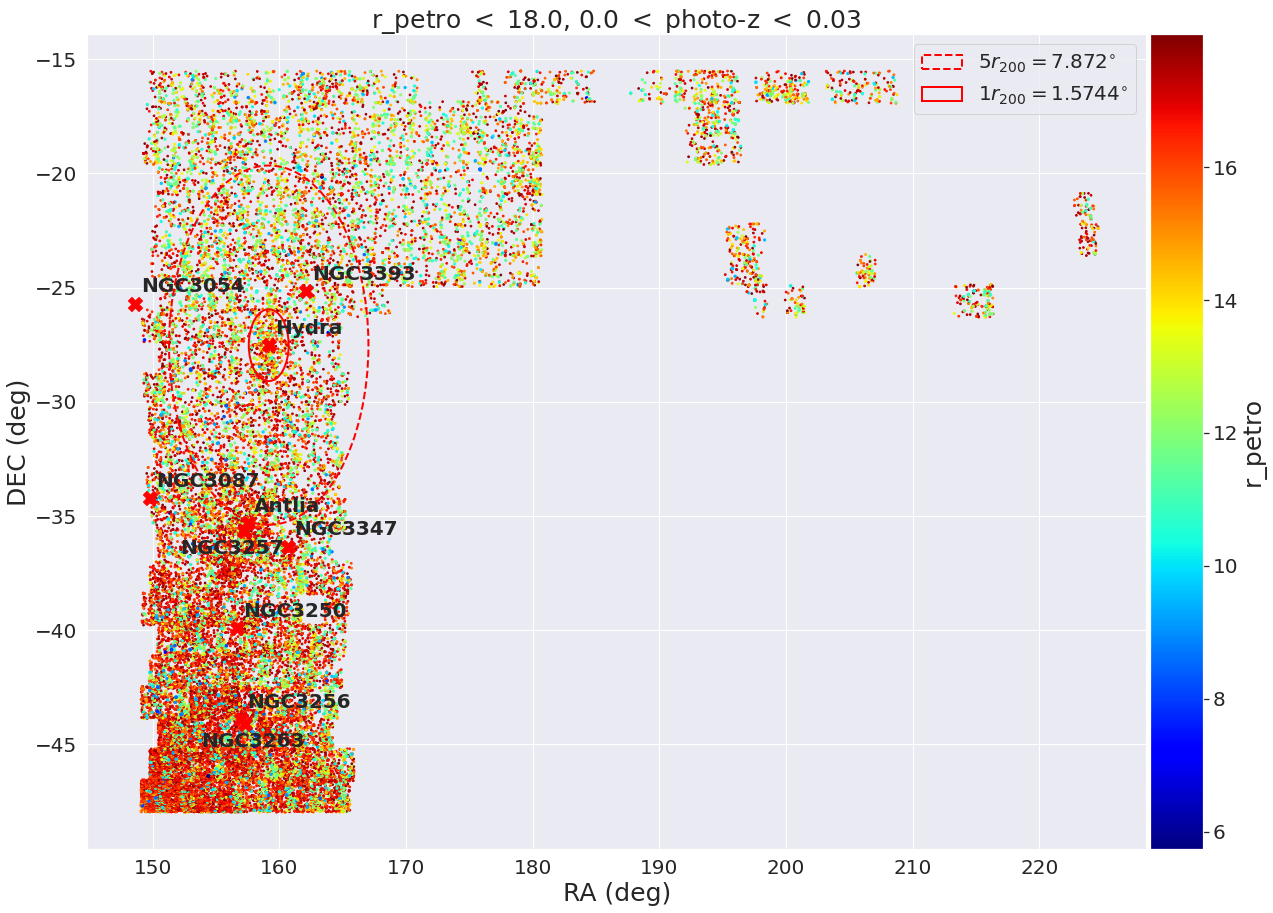

In [57]:
fontsize = 25
labelsize = 20

from mpl_toolkits.axes_grid1 import make_axes_locatable
cm1 = plt.cm.get_cmap('jet')
cm2 = plt.cm.get_cmap('rainbow')

fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111)

sc1 = ax.scatter(x=ra_cor[mask_cor], y=dec_cor[mask_cor], c=rpetro_cor[mask_cor], cmap=cm1, s=(1/rpetro_cor[mask_cor])*50)
ax.set_ylabel("DEC (deg)", fontsize=fontsize)
ax.set_xlabel("RA (deg)", fontsize=fontsize)
ax.set_title(r"r_petro $<$ {:.1f}, 0.0 $<$ photo-z $<$ 0.03".format(mlim), fontsize=fontsize)

ax.scatter(ra_groups, dec_groups, marker='X', s=200.0, color='red')

dx = 0.5
for ra_g, dec_g, text in zip(ra_groups, dec_groups, groups):
    if text=="NGC3257": ax.text(ra_g-10*dx, dec_g-2*dx, s=text, fontsize=20, fontweight='bold')
    elif text=="NGC3263": ax.text(ra_g-7*dx, dec_g-2*dx, s=text, fontsize=20, fontweight='bold')
    else: ax.text(ra_g+dx, dec_g+dx, s=text, fontsize=20, fontweight='bold')

divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="r_petro", fontsize=fontsize)
cbar.ax.tick_params(labelsize=labelsize)

FiveR200 = plt.Circle((ra_0, dec_0), 5*radius, linestyle='--', edgecolor='red', facecolor="None", lw=2, label=r'$5 r_{200} = 7.872^{\circ}$')
ax.add_patch(FiveR200)

OneR200 = plt.Circle((ra_0, dec_0), radius, linestyle='-', edgecolor='red', facecolor="None", lw=2, label=r'$1 r_{200} = 1.5744^{\circ}$')
ax.add_patch(OneR200)

ax.legend(fontsize=fontsize*0.8)
ax.xaxis.set_tick_params(labelsize=20, width=35)
ax.yaxis.set_tick_params(labelsize=20, width=35)

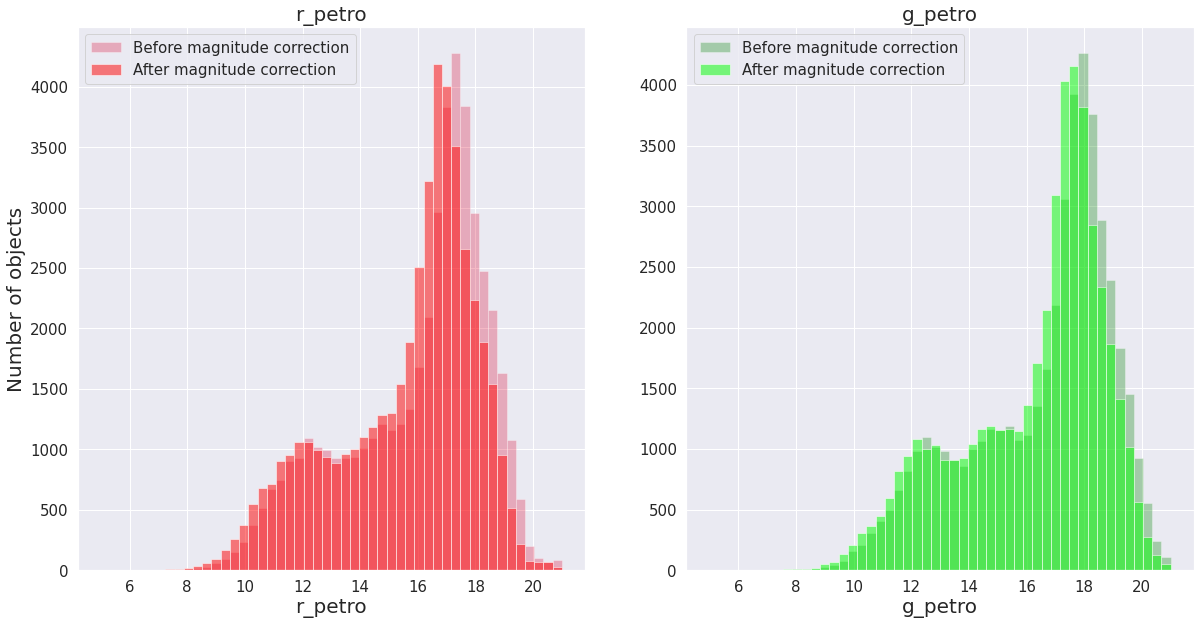

In [53]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.hist(rpetro[mask], color='crimson', label="Before magnitude correction", 
                         alpha=0.3, bins=50, range=[5, 21])
ax1.hist(rpetro_cor, color='red', label="After magnitude correction", 
                         alpha=0.5, bins=50, range=[5, 21])
ax1.set_title("r_petro", fontsize=20)
ax1.set_xlabel("r_petro", fontsize=20)
ax1.set_ylabel("Number of objects", fontsize=20)

ax2.hist(gpetro[mask], color='green', label="Before magnitude correction", 
                        alpha=0.3, bins=50, range=[5, 21])
ax2.hist(gpetro_cor, color='lime', label="After magnitude correction", 
                        alpha=0.5, bins=50, range=[5, 21])
ax2.set_title("g_petro", fontsize=20)
ax2.set_xlabel("g_petro", fontsize=20)

for ax in [ax1, ax2]:
    ax.legend(fontsize=fontsize*0.6)
    ax.xaxis.set_tick_params(labelsize=15, width=35)
    ax.yaxis.set_tick_params(labelsize=15, width=35)

### Plot RA x DEC using right distances:

In [2]:
def angdis(RA1,DEC1,RA2,DEC2):
    '''
    Recebe dois pares de coordenadas e devolve a distância angular em segundos de arco
    '''
    cosA = np.sin(DEC1*pi/180)*np.sin(DEC2*pi/180)+np.cos(DEC1*pi/180)*np.cos(DEC2*pi/180)*np.cos((RA1-RA2)*pi/180)
    if abs(cosA) > 1:
        A = -999*3600
    else:
        A = np.arccos(cosA)*180*3600/pi
    return(A)